In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

try:
    import pennylane as qml
    from pennylane import numpy as pnp
    print(f'PennyLane version: {qml.__version__}')
except ImportError:
    raise ImportError('Install PennyLane: pip install pennylane')

REPO_ROOT = os.path.abspath('..') if os.path.basename(os.getcwd()) == 'notebooks' else os.getcwd()
DATA_PROC = os.path.join(REPO_ROOT, 'data', 'processed')
print(f'Repo root: {REPO_ROOT}')

PennyLane version: 0.44.0
Repo root: C:\Users\PhotonUser\My Files\OneDrive\Files\Manzanillo\manzanillo-digital-twin


---
## 1. Load Candidate Sensor Locations and Risk Scores

In [2]:
# ── 1A. Load Chris's 25 candidate sensor locations ────────────────────────────
sensor_path = os.path.join(DATA_PROC, 'optimized_sensor_network.csv')

if os.path.exists(sensor_path):
    df_candidates = pd.read_csv(sensor_path)
    print(f'Loaded {len(df_candidates)} candidate locations from Chris\'s K-Means output')
    print(f'Layers: {df_candidates["layer"].value_counts().to_dict()}')
else:
    # Fallback: synthetic candidates based on zones.json bounding boxes
    print('Sensor network file not found — generating synthetic candidates from zones.json bounds')
    np.random.seed(42)
    n = 25
    lats = np.random.uniform(19.03, 19.18, n)
    lons = np.random.uniform(-104.35, -104.15, n)
    layers = ['Asset_Defense'] * 15 + ['Wildland_Perimeter'] * 10
    df_candidates = pd.DataFrame({'latitude': lats, 'longitude': lons, 'layer': layers,
                                   'sensor_id': [f'SYN_{i:02d}' for i in range(n)]})

print(df_candidates.head())

Loaded 25 candidate locations from Chris's K-Means output
Layers: {'Asset_Defense': 15, 'Wildland_Perimeter': 10}
    latitude   longitude          layer sensor_id
0  19.095880 -104.283001  Asset_Defense  Asset_00
1  19.027243 -104.274907  Asset_Defense  Asset_01
2  19.073800 -104.282905  Asset_Defense  Asset_02
3  19.027595 -104.318755  Asset_Defense  Asset_03
4  19.085413 -104.284007  Asset_Defense  Asset_04


In [3]:
# ── 1B. Assign risk scores to each candidate location ─────────────────────────
# Option A: Sample from the actual risk map TIF (preferred)
# Option B: Synthetic risk scores (fallback)

risk_map_path = os.path.join(DATA_PROC, 'daily_fire_risk_map.tif')
risk_scores = np.zeros(len(df_candidates))

if os.path.exists(risk_map_path):
    try:
        import rasterio
        with rasterio.open(risk_map_path) as src:
            for i, row in df_candidates.iterrows():
                try:
                    r, c = src.index(row['longitude'], row['latitude'])
                    if 0 <= r < src.height and 0 <= c < src.width:
                        val = src.read(1)[r, c]
                        risk_scores[i] = max(0, float(val))
                except:
                    risk_scores[i] = 0.0
        print(f'Risk scores sampled from real risk map')
    except ImportError:
        print('rasterio not installed — using synthetic risk scores')
        risk_scores = np.random.uniform(0, 100, len(df_candidates))
else:
    print('Risk map not found — using synthetic risk scores for demonstration')
    # Assign higher risk to Wildland_Perimeter sensors (physically realistic)
    base = np.random.uniform(10, 60, len(df_candidates))
    boost = np.where(df_candidates['layer'] == 'Wildland_Perimeter', 30, 0)
    risk_scores = np.clip(base + boost, 0, 100)

# Normalize to [0, 1] for QUBO
r_max = risk_scores.max()
risk_norm = risk_scores / r_max if r_max > 0 else risk_scores

df_candidates['risk_score_raw'] = risk_scores
df_candidates['risk_score_norm'] = risk_norm

print(f'Risk score stats: min={risk_scores.min():.1f}, max={risk_scores.max():.1f}, mean={risk_scores.mean():.1f}')
print(df_candidates[['sensor_id','layer','risk_score_raw','risk_score_norm']].head(8))

Risk scores sampled from real risk map
Risk score stats: min=0.0, max=49.1, mean=32.6
  sensor_id          layer  risk_score_raw  risk_score_norm
0  Asset_00  Asset_Defense       34.272892         0.697443
1  Asset_01  Asset_Defense       43.558739         0.886407
2  Asset_02  Asset_Defense       45.828842         0.932603
3  Asset_03  Asset_Defense       41.604408         0.846637
4  Asset_04  Asset_Defense       43.791225         0.891138
5  Asset_05  Asset_Defense        0.000000         0.000000
6  Asset_06  Asset_Defense       42.639122         0.867693
7  Asset_07  Asset_Defense       43.905216         0.893458


---
## 2. Classical Baseline — Greedy Solver
Before quantum, always establish a classical baseline. The greedy solution simply picks
the top-K locations by risk score. This is the benchmark the QUBO must beat.

In [4]:
# ── 2. Greedy baseline ────────────────────────────────────────────────────────
K_BUDGET = 8   # Number of sensors we can deploy (budget constraint)
LAMBDA   = 5.0 # Penalty weight for budget violation (tune this)

N = len(df_candidates)
r = risk_norm  # normalized risk scores

# Greedy: sort by risk, take top K
greedy_idx = np.argsort(r)[::-1][:K_BUDGET]
greedy_coverage = r[greedy_idx].sum()

print(f'Problem size: N={N} candidate locations, K={K_BUDGET} budget')
print(f'Greedy solution: deploy at indices {sorted(greedy_idx)}')
print(f'Greedy total risk coverage: {greedy_coverage:.4f} (normalized)')
print(f'  = {greedy_coverage * r_max:.1f} points (raw risk score units)')
print()
print('Greedy selected locations:')
print(df_candidates.iloc[greedy_idx][['sensor_id','layer','latitude','longitude','risk_score_raw']])

Problem size: N=25 candidate locations, K=8 budget
Greedy solution: deploy at indices [np.int64(2), np.int64(4), np.int64(7), np.int64(8), np.int64(18), np.int64(19), np.int64(20), np.int64(23)]
Greedy total risk coverage: 7.4670 (normalized)
  = 366.9 points (raw risk score units)

Greedy selected locations:
      sensor_id               layer   latitude   longitude  risk_score_raw
18  Wildland_18  Wildland_Perimeter  19.100253 -104.296881       49.140789
19  Wildland_19  Wildland_Perimeter  19.099644 -104.346578       47.753147
20  Wildland_20  Wildland_Perimeter  19.071938 -104.266620       47.505150
2      Asset_02       Asset_Defense  19.073800 -104.282905       45.828842
8      Asset_08       Asset_Defense  19.084790 -104.273327       45.384960
7      Asset_07       Asset_Defense  19.010278 -104.270430       43.905216
4      Asset_04       Asset_Defense  19.085413 -104.284007       43.791225
23  Wildland_23  Wildland_Perimeter  19.019730 -104.299460       43.626785


---
## 3. QUBO Construction
Build the Q matrix for the sensor placement problem.

In [5]:
# ── 3. Build QUBO Q matrix ────────────────────────────────────────────────────
#
# H = -sum_i r_i * x_i  +  lambda * (sum_i x_i - K)^2
#
# Expanding the constraint term:
#   lambda * (sum_i x_i - K)^2
#   = lambda * [sum_i x_i^2 + 2*sum_{i<j} x_i*x_j - 2K*sum_i x_i + K^2]
#   = lambda * [sum_i x_i + 2*sum_{i<j} x_i*x_j - 2K*sum_i x_i + K^2]
#   (using x_i^2 = x_i for binary variables)
#
# So the full QUBO Q matrix (upper triangular form):
#   Q[i,i] = -r_i + lambda*(1 - 2K)          (diagonal: linear terms)
#   Q[i,j] = 2*lambda  for i < j              (off-diagonal: quadratic penalty)
#   constant = lambda * K^2                   (ignored in optimization)

Q = np.zeros((N, N))

# Diagonal (linear terms)
for i in range(N):
    Q[i, i] = -r[i] + LAMBDA * (1 - 2 * K_BUDGET)

# Off-diagonal (quadratic penalty for co-selection)
for i in range(N):
    for j in range(i + 1, N):
        Q[i, j] = 2 * LAMBDA

constant = LAMBDA * K_BUDGET ** 2

print(f'QUBO Q matrix shape: {Q.shape}')
print(f'Constant offset: {constant:.2f}')
print(f'Q diagonal (first 5): {np.diag(Q)[:5].round(3)}')
print(f'Q off-diagonal sample Q[0,1]: {Q[0,1]:.3f}')
print()
print('Interpretation:')
print(f'  Negative diagonal = incentive to select (risk coverage reward)')
print(f'  Positive off-diagonal = penalty for selecting too many (budget enforcement)')
print(f'  lambda={LAMBDA} — increase to enforce budget harder, decrease for softer constraint')

QUBO Q matrix shape: (25, 25)
Constant offset: 320.00
Q diagonal (first 5): [-75.697 -75.886 -75.933 -75.847 -75.891]
Q off-diagonal sample Q[0,1]: 10.000

Interpretation:
  Negative diagonal = incentive to select (risk coverage reward)
  Positive off-diagonal = penalty for selecting too many (budget enforcement)
  lambda=5.0 — increase to enforce budget harder, decrease for softer constraint


In [6]:
# ── 3B. Classical energy function (to evaluate any binary solution) ───────────
def qubo_energy(x, Q, constant=0.0):
    """Compute QUBO energy E = x^T Q x + constant.
    Lower energy = better solution.
    """
    return float(x @ Q @ x) + constant

def solution_stats(x, r, K, label='Solution'):
    selected = np.where(x == 1)[0]
    n_selected = len(selected)
    coverage = r[selected].sum()
    energy = qubo_energy(x, Q, constant)
    budget_ok = n_selected <= K
    print(f'{label}:')
    print(f'  Selected: {n_selected} sensors (budget={K}) — {"✅ within budget" if budget_ok else "❌ over budget"}')
    print(f'  Risk coverage (normalized): {coverage:.4f}')
    print(f'  QUBO energy: {energy:.4f}')
    return coverage, energy

# Evaluate greedy solution
x_greedy = np.zeros(N, dtype=int)
x_greedy[greedy_idx] = 1
greedy_cov, greedy_E = solution_stats(x_greedy, r, K_BUDGET, 'Greedy baseline')

Greedy baseline:
  Selected: 8 sensors (budget=8) — ✅ within budget
  Risk coverage (normalized): 7.4670
  QUBO energy: -7.4670


---
## 4. Classical Simulated Annealing (same approach as Chris's quantum_bridge.py)
Before QAOA, use simulated annealing to get an optimal classical reference.

In [7]:
# ── 4. Simulated Annealing (classical reference, mirrors Chris's dimod approach) ─
def simulated_annealing_qubo(Q, n_steps=50000, T_start=5.0, T_end=0.01):
    """Minimize QUBO energy using simulated annealing."""
    N = Q.shape[0]
    x = np.random.randint(0, 2, N)  # random initial solution
    E = qubo_energy(x, Q)
    best_x, best_E = x.copy(), E

    temps = np.linspace(T_start, T_end, n_steps)
    for step, T in enumerate(temps):
        flip = np.random.randint(N)
        x_new = x.copy()
        x_new[flip] = 1 - x_new[flip]
        E_new = qubo_energy(x_new, Q)
        dE = E_new - E
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            x, E = x_new, E_new
            if E < best_E:
                best_x, best_E = x.copy(), E
    return best_x, best_E

np.random.seed(42)
x_sa, E_sa = simulated_annealing_qubo(Q)
sa_cov, _ = solution_stats(x_sa, r, K_BUDGET, 'Simulated Annealing')

Simulated Annealing:
  Selected: 8 sensors (budget=8) — ✅ within budget
  Risk coverage (normalized): 7.4469
  QUBO energy: -7.4469


---
## 5. QAOA with PennyLane
Quantum Approximate Optimization Algorithm on a toy-size subproblem.

**Note on scale:** QAOA requires one qubit per binary variable. 25 qubits is feasible
on a simulator but would require a real QPU for production. We demonstrate on the full
25-variable problem using the default PennyLane statevector simulator.

In [8]:
# ── 5A. Convert QUBO to Ising Hamiltonian ─────────────────────────────────────
#
# QUBO variable x_i ∈ {0,1} maps to Ising spin s_i ∈ {-1,+1} via: x_i = (1 - s_i)/2
# This converts the QUBO objective to a sum of Pauli-Z terms.

def qubo_to_ising(Q):
    """Convert QUBO Q matrix to Ising J (coupling) and h (bias) with offset.
    Returns: h (N,), J (N,N upper triangular), offset scalar
    """
    N = Q.shape[0]
    h = np.zeros(N)
    J = np.zeros((N, N))
    offset = 0.0

    for i in range(N):
        h[i] += Q[i, i] / 2
        offset += Q[i, i] / 2
        for j in range(i + 1, N):
            J[i, j] += Q[i, j] / 4
            h[i] += Q[i, j] / 4
            h[j] += Q[i, j] / 4
            offset += Q[i, j] / 4

    return h, J, offset

h_ising, J_ising, offset_ising = qubo_to_ising(Q)

print(f'Ising conversion complete')
print(f'h (bias) range: [{h_ising.min():.3f}, {h_ising.max():.3f}]')
print(f'J (coupling) range (non-zero): [{J_ising[J_ising!=0].min():.3f}, {J_ising[J_ising!=0].max():.3f}]')

Ising conversion complete
h (bias) range: [22.000, 22.500]
J (coupling) range (non-zero): [2.500, 2.500]


In [9]:
# ── 5B. Build PennyLane Cost Hamiltonian ──────────────────────────────────────
# We use a reduced problem (top M candidates by risk) to keep qubit count manageable
# For production, use all N=25. For demo on slow hardware, reduce to M=10.

M = min(N, 12)   # Adjust: 12 qubits runs fast on CPU simulator; increase for GPU/QPU
K_sub = max(1, int(K_BUDGET * M / N))  # Scale budget proportionally

# Select top-M candidates by risk (most meaningful subproblem)
top_M_idx = np.argsort(r)[::-1][:M]
r_sub = r[top_M_idx]

# Build sub-QUBO
Q_sub = np.zeros((M, M))
for i in range(M):
    Q_sub[i, i] = -r_sub[i] + LAMBDA * (1 - 2 * K_sub)
for i in range(M):
    for j in range(i + 1, M):
        Q_sub[i, j] = 2 * LAMBDA

h_sub, J_sub, offset_sub = qubo_to_ising(Q_sub)

print(f'QAOA problem size: {M} qubits (subset of top-{M} locations by risk)')
print(f'Sub-budget: K_sub={K_sub} sensors')
print(f'Sub-risk scores: {r_sub.round(3)}')

QAOA problem size: 12 qubits (subset of top-12 locations by risk)
Sub-budget: K_sub=3 sensors
Sub-risk scores: [1.    0.972 0.967 0.933 0.924 0.893 0.891 0.888 0.886 0.886 0.882 0.874]


In [10]:
# ── 5C. QAOA Circuit Definition ───────────────────────────────────────────────
P = 2  # QAOA depth (number of layers). Increase for better approximation quality.

dev = qml.device('default.qubit', wires=M)

def cost_hamiltonian(h, J):
    """Build PennyLane Hamiltonian from Ising h and J."""
    coeffs, ops = [], []
    for i in range(len(h)):
        if abs(h[i]) > 1e-10:
            coeffs.append(h[i])
            ops.append(qml.PauliZ(i))
    for i in range(len(J)):
        for j in range(i + 1, len(J)):
            if abs(J[i, j]) > 1e-10:
                coeffs.append(J[i, j])
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    return qml.Hamiltonian(coeffs, ops)

def mixer_hamiltonian(n_qubits):
    """Standard X-mixer."""
    coeffs = [-1.0] * n_qubits
    ops = [qml.PauliX(i) for i in range(n_qubits)]
    return qml.Hamiltonian(coeffs, ops)

H_cost  = cost_hamiltonian(h_sub, J_sub)
H_mixer = mixer_hamiltonian(M)

@qml.qnode(dev)
def qaoa_circuit(params):
    gammas = params[:P]   # cost layer angles
    betas  = params[P:]   # mixer layer angles

    # Initial state: equal superposition |+>^N
    for i in range(M):
        qml.Hadamard(wires=i)

    # P QAOA layers
    for p in range(P):
        qml.CommutingEvolution(H_cost,  gammas[p])
        qml.CommutingEvolution(H_mixer, betas[p])

    return qml.expval(H_cost)

print(f'QAOA circuit defined: {M} qubits, {P} layers, {2*P} parameters')
print(f'Cost Hamiltonian terms: {len(H_cost.coeffs)}')
print(f'Mixer Hamiltonian terms: {len(H_mixer.coeffs)}')

QAOA circuit defined: 12 qubits, 2 layers, 4 parameters
Cost Hamiltonian terms: 78
Mixer Hamiltonian terms: 12


In [11]:
# ── 5D. QAOA Optimization ─────────────────────────────────────────────────────
np.random.seed(42)
init_params = np.random.uniform(0, np.pi, 2 * P)

opt = qml.GradientDescentOptimizer(stepsize=0.1)
params = pnp.array(init_params, requires_grad=True)

energy_history = []
N_STEPS = 60   # Increase to 200+ for production

print(f'Running QAOA optimization ({N_STEPS} gradient steps)...')
for step in range(N_STEPS):
    params, E = opt.step_and_cost(qaoa_circuit, params)
    energy_history.append(float(E))
    if step % 10 == 0:
        print(f'  Step {step:3d}: energy = {E:.4f}')

print(f'\nFinal energy: {energy_history[-1]:.4f}')
print(f'Energy reduction: {energy_history[0] - energy_history[-1]:.4f}')

Running QAOA optimization (60 gradient steps)...
  Step   0: energy = 27.9695
  Step  10: energy = 13.5832
  Step  20: energy = -11.8788
  Step  30: energy = -2.5467
  Step  40: energy = -2.7265
  Step  50: energy = 10.1390

Final energy: 29.3683
Energy reduction: -1.3988


In [12]:
# ── 5E. Sample bitstrings from optimized circuit ──────────────────────────────
@qml.qnode(dev)
def qaoa_sample(params, n_shots=1000):
    gammas = params[:P]
    betas  = params[P:]
    for i in range(M):
        qml.Hadamard(wires=i)
    for p in range(P):
        qml.CommutingEvolution(H_cost,  gammas[p])
        qml.CommutingEvolution(H_mixer, betas[p])
    return qml.counts(wires=range(M))

# PennyLane counts returns bitstring → count dict
# We use the sampling device instead
dev_sample = qml.device('default.qubit', wires=M, shots=2000)

@qml.qnode(dev_sample)
def qaoa_sample_circuit(params):
    gammas = params[:P]
    betas  = params[P:]
    for i in range(M):
        qml.Hadamard(wires=i)
    for p in range(P):
        qml.CommutingEvolution(H_cost,  gammas[p])
        qml.CommutingEvolution(H_mixer, betas[p])
    return qml.counts(all_outcomes=False)

counts = qaoa_sample_circuit(params)

# Find the most frequent valid (within budget) bitstring
best_bitstring = None
best_count = 0
best_valid_energy = float('inf')

for bitstring, count in counts.items():
    # bitstring is a tuple of 0/1 measurements
    if isinstance(bitstring, (list, tuple, np.ndarray)):
        x = np.array(bitstring, dtype=int)
    else:
        x = np.array([int(b) for b in str(bitstring)], dtype=int)

    if len(x) != M:
        continue
    n_selected = x.sum()
    if n_selected <= K_sub:  # within budget
        E_bs = qubo_energy(x, Q_sub)
        if E_bs < best_valid_energy:
            best_valid_energy = E_bs
            best_bitstring = x
            best_count = count

if best_bitstring is not None:
    selected_sub = np.where(best_bitstring == 1)[0]
    selected_global = top_M_idx[selected_sub]
    qaoa_cov = r[selected_global].sum()

    print(f'Best QAOA bitstring (sampled): {best_bitstring}')
    print(f'Selected {best_bitstring.sum()} of {M} candidates (budget={K_sub})')
    print(f'QAOA risk coverage (normalized): {qaoa_cov:.4f}')
    print(f'Sampled {best_count} times out of 2000 shots')
    print()
    print('QAOA-selected locations:')
    print(df_candidates.iloc[selected_global][['sensor_id','layer','latitude','longitude','risk_score_raw']])
else:
    print('No valid (within-budget) bitstring found in samples — increase shots or reduce lambda')
    qaoa_cov = 0.0
    selected_global = []

Best QAOA bitstring (sampled): [1 1 1 0 0 0 0 0 0 0 0 0]
Selected 3 of 12 candidates (budget=3)
QAOA risk coverage (normalized): 2.9385
Sampled 1 times out of 2000 shots

QAOA-selected locations:
      sensor_id               layer   latitude   longitude  risk_score_raw
18  Wildland_18  Wildland_Perimeter  19.100253 -104.296881       49.140789
19  Wildland_19  Wildland_Perimeter  19.099644 -104.346578       47.753147
20  Wildland_20  Wildland_Perimeter  19.071938 -104.266620       47.505150


---
## 6. Results Comparison & Visualization

In [13]:
# ── 6A. Results table ─────────────────────────────────────────────────────────
print('=' * 60)
print('SOLVER COMPARISON SUMMARY')
print('=' * 60)
print(f'Problem: N={N} locations, K={K_BUDGET} budget (QAOA subproblem: M={M}, K_sub={K_sub})')
print()

results_df = pd.DataFrame([
    {'Solver': 'Greedy (classical)',
     'Sensors Selected': int(x_greedy.sum()),
     'Risk Coverage (norm)': float(greedy_cov),
     'QUBO Energy': float(greedy_E),
     'Within Budget': bool(x_greedy.sum() <= K_BUDGET)},
    {'Solver': 'Simulated Annealing (classical)',
     'Sensors Selected': int(x_sa.sum()),
     'Risk Coverage (norm)': float(sa_cov),
     'QUBO Energy': float(E_sa),
     'Within Budget': bool(x_sa.sum() <= K_BUDGET)},
    {'Solver': f'QAOA (P={P} layers, subproblem M={M})',
     'Sensors Selected': int(len(selected_global)),
     'Risk Coverage (norm)': float(qaoa_cov),
     'QUBO Energy': float(best_valid_energy) if best_bitstring is not None else None,
     'Within Budget': True},
])

print(results_df.to_string(index=False))
print()
print('NOTE: QAOA operates on a subproblem (top M locations). Direct coverage comparison')
print('with Greedy/SA is not apples-to-apples until full problem size is implemented.')
print('This template is designed for benchmarking expansion — see Week 3 tasks below.')

SOLVER COMPARISON SUMMARY
Problem: N=25 locations, K=8 budget (QAOA subproblem: M=12, K_sub=3)

                            Solver  Sensors Selected  Risk Coverage (norm)  QUBO Energy  Within Budget
                Greedy (classical)                 8              7.467038    -7.467038           True
   Simulated Annealing (classical)                 8              7.446939  -327.446939           True
QAOA (P=2 layers, subproblem M=12)                 3              2.938477   -47.938477           True

NOTE: QAOA operates on a subproblem (top M locations). Direct coverage comparison
with Greedy/SA is not apples-to-apples until full problem size is implemented.
This template is designed for benchmarking expansion — see Week 3 tasks below.


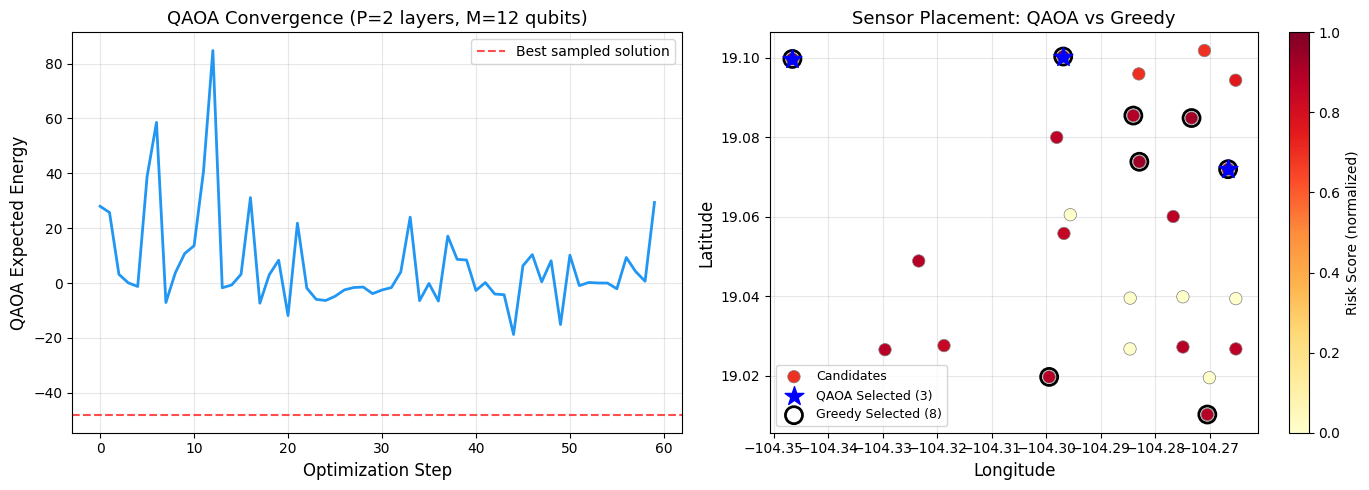

Plot saved to data/processed/qubo_sensor_placement_results.png


In [14]:
# ── 6B. Convergence plot ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: QAOA convergence
axes[0].plot(energy_history, color='#2196F3', linewidth=2)
axes[0].set_xlabel('Optimization Step', fontsize=12)
axes[0].set_ylabel('QAOA Expected Energy', fontsize=12)
axes[0].set_title(f'QAOA Convergence (P={P} layers, M={M} qubits)', fontsize=13)
axes[0].grid(alpha=0.3)
axes[0].axhline(best_valid_energy if best_bitstring is not None else energy_history[-1],
                color='red', linestyle='--', alpha=0.7, label='Best sampled solution')
axes[0].legend()

# Plot 2: Map of candidate locations
lats = df_candidates['latitude'].values
lons = df_candidates['longitude'].values
risks = df_candidates['risk_score_norm'].values

sc = axes[1].scatter(lons, lats, c=risks, cmap='YlOrRd', s=80,
                     edgecolors='gray', linewidths=0.5, zorder=2, label='Candidates')
plt.colorbar(sc, ax=axes[1], label='Risk Score (normalized)')

# Highlight QAOA selected
if len(selected_global) > 0:
    axes[1].scatter(lons[selected_global], lats[selected_global],
                    c='blue', s=200, marker='*', zorder=5, label=f'QAOA Selected ({len(selected_global)})')

# Highlight greedy selected
axes[1].scatter(lons[greedy_idx], lats[greedy_idx],
                facecolors='none', edgecolors='black', s=150,
                linewidths=2, zorder=4, label=f'Greedy Selected ({K_BUDGET})')

axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('Sensor Placement: QAOA vs Greedy', fontsize=13)
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DATA_PROC, 'qubo_sensor_placement_results.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Plot saved to data/processed/qubo_sensor_placement_results.png')

In [15]:
# ── Final summary ─────────────────────────────────────────────────────────────
print('QUBO FORMULATION SUMMARY')
print('=' * 50)
print(f'Variables:           {N} binary (x_i ∈ {{0,1}})')
print(f'Objective:           maximize Σ r_i·x_i (risk coverage)')
print(f'Budget constraint:   Σ x_i ≤ {K_BUDGET}')
print(f'Penalty lambda:      {LAMBDA}')
print(f'QAOA qubits:         {M} (subproblem)')
print(f'QAOA layers (P):     {P}')
print(f'Optimization steps:  {N_STEPS}')
print(f'Shots for sampling:  2000')
print()
print('Files generated:')
print(f'  data/processed/qubo_sensor_placement_results.png')
print()
print('This notebook is ready for Week 3 benchmarking expansion.')

QUBO FORMULATION SUMMARY
Variables:           25 binary (x_i ∈ {0,1})
Objective:           maximize Σ r_i·x_i (risk coverage)
Budget constraint:   Σ x_i ≤ 8
Penalty lambda:      5.0
QAOA qubits:         12 (subproblem)
QAOA layers (P):     2
Optimization steps:  60
Shots for sampling:  2000

Files generated:
  data/processed/qubo_sensor_placement_results.png

This notebook is ready for Week 3 benchmarking expansion.
